In [1]:
#Prepare 256x256 tiles from NASA map

In [2]:
from skimage.io import imread
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time
import h5py

In [3]:
# Decompression protection override only run on trusted files
Image.MAX_IMAGE_PIXELS = None

In [4]:
texture = imread("data/word.3x21600x10800.jpg")
print(texture.shape)

(10800, 21600, 3)


In [5]:
heightmap = imread("data/heightmap.3x21600x10800JPG.jpg")
print(heightmap.shape)

(10800, 21600, 3)


In [6]:
# Test tresholding for heightmaps

In [7]:
# generate random offset

yoff = np.random.randint(0, heightmap.shape[0])
xoff = np.random.randint(0, heightmap.shape[1])
print(yoff)
print(xoff)

380
10822


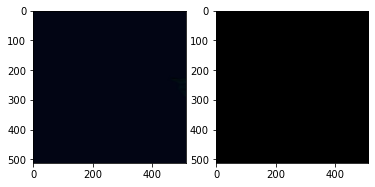

In [8]:
#crop images

texture_crp = texture[yoff:yoff+512, xoff:xoff+512]
heightmap_crp = heightmap[yoff:yoff+512, xoff:xoff+512]

#show plots
plt.subplot(1,2,1)
plt.imshow(texture_crp)
plt.subplot(1,2,2)
plt.imshow(heightmap_crp, cmap="gray")

In [9]:
#show ratio of white to black
crp_sum = (heightmap_crp==0).sum()*1.0
print(crp_sum)
crp_size = np.prod(heightmap_crp.shape)
print(crp_size)
black_ratio = crp_sum / float(crp_size)
print(black_ratio)



786432.0
786432
1.0


In [10]:
def comparator(heightmap_chunk):
    # returns True if we should keep the chunk, otherwise False to discard it
    # counts how mucj black is there in the heightmap
    black_ratio = ((heightmap_chunk==0).sum()*1.0)/float(np.prod(heightmap_chunk.shape))
    if black_ratio > 0.9:
        return False
    return True

In [11]:
def get_chunks(img, img2, crop_size=1000, stride=1, max_n=None, debug=False, dry_run=False):
    #img: texture map, img2: height map
    assert img.shape[0] == img2.shape[0] and img.shape[1] == img2.shape[1]
    ctr = 0
    is_done = False
    for y in range(0, img.shape[0], stride):
        for x in range(0, img.shape[1], stride):
            chunk = img[y:y+crop_size, x:x+crop_size] #texture
            chunk2 = img2[y:y+crop_size,x:x+crop_size] #[:,:,np.newaxis] #heightmap
            if chunk.shape != (crop_size, crop_size, 3):
                continue
            if not comparator(chunk2):
                continue
            if dry_run:
                yield None
            else:
                yield chunk, chunk2
                ctr += 1
            if max_n != None and ctr == max_n:
                return

In [12]:
# create index, to see how many images must be saved

In [13]:
t0 = time.time()
ctr2 = 0
for chunk in get_chunks(texture, heightmap, crop_size=256, stride=500, max_n=None):
    ctr2 += 1
print("time taken to process: %f sec" % (time.time()-t0))
print("number of patches detected: %i" % ctr2)

time taken to process: 0.555002 sec
number of patches detected: 388


In [14]:
num_train = int(ctr2*0.9)
num_valid = int(ctr2*0.1)
'''
OUT_FILE = 'data_256x256.hd5'
f = h5py.File(OUT_FILE, 'w')
f.create_dataset('xt', (num_train, 256, 256, 1), dtype='uint8')
f.create_dataset('yt', (num_train, 256, 256, 3), dtype='uint8')
f.create_dataset('xv', (num_valid, 256, 256, 1), dtype='uint8')
f.create_dataset('yv', (num_valid, 256, 256, 3), dtype='uint8')
'''


"\nOUT_FILE = 'data_256x256.hd5'\nf = h5py.File(OUT_FILE, 'w')\nf.create_dataset('xt', (num_train, 256, 256, 1), dtype='uint8')\nf.create_dataset('yt', (num_train, 256, 256, 3), dtype='uint8')\nf.create_dataset('xv', (num_valid, 256, 256, 1), dtype='uint8')\nf.create_dataset('yv', (num_valid, 256, 256, 3), dtype='uint8')\n"

In [15]:
idxs = [x for x in range(ctr2)]
rnd_state = np.random.RandomState(0)
rnd_state.shuffle(idxs)

print(ctr2)

388


In [16]:
OUT_FILE = 'data_256x256.hdf5'

f = h5py.File(OUT_FILE, 'w')
f.create_dataset('sketches', (ctr2, 256, 256, 3), dtype='uint8')
#f.create_dataset('heightmaps', (ctr2, 256, 256, 1), dtype='uint8')
f.create_dataset('heightmaps', (ctr2, 256, 256, 3), dtype='uint8')

t0 = time.time()
ctr3 = 0
for chunk1, chunk2 in get_chunks(texture, heightmap, crop_size=256, stride=500, max_n=None):
    f["sketches"][idxs[ctr3]]=chunk2
    f["heightmaps"][idxs[ctr3]]=chunk1
    ctr3 += 1

print(time.time()-t0)
print("number of patches detected:", ctr3)

1.8873178958892822
number of patches detected: 388


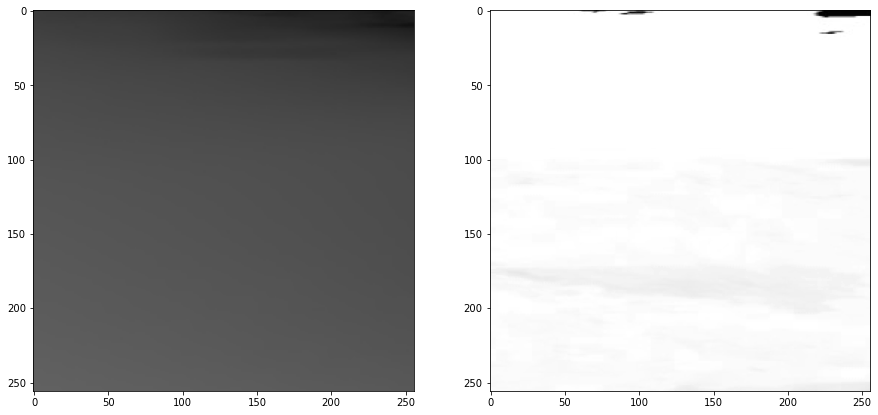

In [17]:
idx = 100
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(f['sketches'][idx]) #10000
plt.subplot(1,2,2)
plt.imshow(f['heightmaps'][idx][0:,:,0],cmap="gray")

In [18]:
f.close()